In [1]:
%matplotlib inline
import os
import shutil
import json
import cPickle as pickle
from string import punctuation
from random import choice

import nltk
import numpy as np
from tqdm import tqdm
import pandas as pd

import sys
import os
import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import classification_report, roc_auc_score

from random import sample, seed

In [2]:
# os.system("shuf -n 20000 ../data/yelp_academic_dataset_review.json > ../data/yelp_academic_dataset_review_samp.json")

In [3]:
data_path = '../data'
reviews_path = os.path.join(data_path,'yelp_academic_dataset_review_samp.json')

In [47]:
seed(101)

# If new data

In [7]:
reviews = []
ratings = []

# Stem reviews before saving them
stemmer = nltk.stem.porter.PorterStemmer()
with open(reviews_path) as review_file:
    for line in tqdm(review_file):
        # Set reviews to positive or negative
        # Load review text
        review_json = json.loads(line)
        stars = review_json['stars']
        if stars > 3 or stars < 3:
            review_text = review_json['text']
            # Remove punctuation
            review_text = ''.join([x for x in review_text if x not in punctuation])
            # Tokenize and stem words and append to data
            review_text = ' '.join([stemmer.stem(x) for x in nltk.word_tokenize(review_text)])
            reviews.append(review_text)
            if stars > 3:
              ratings.append(1)
            elif stars < 3:
              ratings.append(0)

20000it [01:08, 293.83it/s]


In [50]:
# to save
with open(os.path.join(data_path,'data.pickle'), 'wb') as pickle_file:
  pickle.dump(reviews, pickle_file)

with open(os.path.join(data_path,'ratings.pickle'), 'wb') as pickle_file:
  pickle.dump(ratings, pickle_file)

# Otherwise load from pickle

In [5]:
# to load
with open(os.path.join(data_path,'data.pickle'), 'rb') as pickle_file:
  reviews = pickle.load(pickle_file)
with open(os.path.join(data_path,'ratings.pickle'), 'rb') as pickle_file:
  ratings = pickle.load(pickle_file)

# Feed data to model

20000
20000


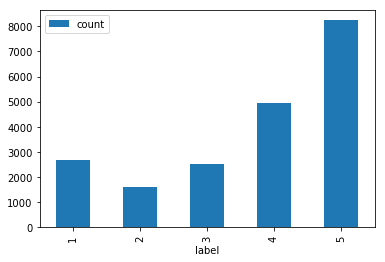

In [49]:
print len(ratings)
print len(reviews)
unique, counts = np.unique(ratings, return_counts=True)
pd.DataFrame(zip(unique, counts),columns=['label','count']).plot.bar(x='label',y='count')

In [7]:
n_train = int(len(reviews)*.8)
n_test = len(reviews)-n_train

In [42]:
ratios = {'train' : .8, 'val' : .1, 'test' : .1}
train_index = np.array(sample(xrange(len(reviews)), int(len(reviews) * ratios['train'])))
val_index = np.array(sample(xrange(len(reviews)), int(len(reviews) * ratios['val'])))
test_index = np.array(sample(xrange(len(reviews)), int(len(reviews) * ratios['test'])))

In [43]:
train_data = np.asarray(reviews).take(train_index)
test_data = np.asarray(reviews).take(test_index)
train_labels = np.asarray(ratings).take(train_index)
test_labels = np.asarray(ratings).take(test_index)
# Create feature vectors
vectorizer = TfidfVectorizer(min_df=5,
                             max_df = 0.8,
                             sublinear_tf=True,
                             use_idf=True)
train_vectors = vectorizer.fit_transform(train_data)
test_vectors = vectorizer.transform(test_data)

In [ ]:
# Perform classification with SVM, kernel=rbf
classifier_rbf = svm.SVC()
t0 = time.time()
classifier_rbf.fit(train_vectors, train_labels)
t1 = time.time()
prediction_rbf = classifier_rbf.predict(test_vectors)
t2 = time.time()
time_rbf_train = t1-t0
time_rbf_predict = t2-t1

# Perform classification with SVM, kernel=linear
classifier_liblinear = svm.LinearSVC()
t0 = time.time()
classifier_liblinear.fit(train_vectors, train_labels)
t1 = time.time()
prediction_liblinear = classifier_liblinear.predict(test_vectors)
t2 = time.time()
time_liblinear_train = t1-t0
time_liblinear_predict = t2-t1

In [44]:
# Perform classification with SVM, kernel=linear
classifier_linear = svm.SVC(kernel='linear', probability=True)
t0 = time.time()
classifier_linear.fit(train_vectors, train_labels)
t1 = time.time()
prediction_linear = classifier_linear.predict(test_vectors)
prediction_linear_proba = classifier_linear.predict_proba(test_vectors)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1

In [45]:
# Print results in a nice table
print("Results for SVC(kernel=rbf)")
print("Training time: %fs; Prediction time: %fs" % (time_rbf_train, time_rbf_predict))
print(classification_report(test_labels, prediction_rbf))

print("Results for SVC(kernel=linear)")
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))
print(classification_report(test_labels, prediction_linear))
print "AUC: ", roc_auc_score(test_labels, prediction_linear_proba[:,1])

print("Results for LinearSVC()")
print("Training time: %fs; Prediction time: %fs" % (time_liblinear_train, time_liblinear_predict))
print(classification_report(test_labels, prediction_liblinear))

Results for SVC(kernel=rbf)
Training time: 647.842000s; Prediction time: 116.378000s
             precision    recall  f1-score   support

          0       0.00      0.00      0.00      2112
          1       0.76      1.00      0.86      6637

avg / total       0.58      0.76      0.65      8749

Results for SVC(kernel=linear)
Training time: 365.154000s; Prediction time: 60.150000s
             precision    recall  f1-score   support

          0       0.90      0.84      0.87      2112
          1       0.95      0.97      0.96      6637

avg / total       0.94      0.94      0.94      8749

AUC:  0.980935011654
Results for LinearSVC()
Training time: 0.315000s; Prediction time: 0.000000s
             precision    recall  f1-score   support

          0       0.23      0.23      0.23      2112
          1       0.76      0.76      0.76      6637

avg / total       0.63      0.63      0.63      8749



# Descriptive

In [ ]:
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

In [ ]:
class_names = ['neg', 'pos']
classifier_linear.classes_

In [ ]:
c = make_pipeline(vectorizer, classifier_linear)
explainer = LimeTextExplainer(class_names=class_names)

In [ ]:
idx = 95
exp = explainer.explain_instance(test_data[idx], c.predict_proba, num_features=8)
print('Document id: %d' % idx)
print('True class: %s' % class_names[test_labels[idx]])
exp.show_in_notebook(text=False)